In [1]:
# this notebooks explainns gradient clipping and learning rate scheduler

In [2]:
import numpy as np
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup


Simple demo of grad clipping

In [28]:
# tensor with gradients (like a weight matrix)
w = torch.tensor([[-1,3.3,2,-5,3,-2,-4,-5,1.5]], requires_grad = True) # consider this is weights in a model

# loss is sum of squares (L2), a dummy loss fun
loss = (w**2).sum()

# backprop
loss.backward()

#print grad and their norm before clipping
print('BEFORE CLIPPING')
print(f'Gradient vals: {w.grad[0].tolist()}')
print(f'Gradeient norm: {torch.norm(w.grad):.3f}')

#apply grad clipping
preClipVals = w.grad[0].detach() + 0
nn.utils.clip_grad_norm_([w],max_norm=1) #this is an inplace fun

print('AFTER CLIPPING')
print(f'Gradient vals: {w.grad[0].tolist()}')
print(f'Gradeient norm: {torch.norm(w.grad):.3f}')


BEFORE CLIPPING
Gradient vals: [-2.0, 6.599999904632568, 4.0, -10.0, 6.0, -4.0, -8.0, -10.0, 3.0]
Gradeient norm: 19.712
AFTER CLIPPING
Gradient vals: [-0.10146141052246094, 0.3348226547241211, 0.20292282104492188, -0.5073070526123047, 0.3043842315673828, -0.20292282104492188, -0.40584564208984375, -0.5073070526123047, 0.1521921157836914]
Gradeient norm: 1.000


In [4]:
w.grad[0]

tensor([-0.1015,  0.3348,  0.2029, -0.5073,  0.3044, -0.2029, -0.4058, -0.5073,
         0.1522])

![title](../images/PrePostClip.png)

In [5]:
# The correlation of pre and post clipped grad values is 1
# that means the indiviidual values doesnt change, the entire matrix of weights values is shrinking down
# such that the norm of their grad is 1

Simple demo of optimizer scheduler

In [22]:
training_steps= 200

# create a dummy model and an otpim
model = nn.Linear(10,10)
optim = torch.optim.AdamW(model.parameters(),lr=3e-5)

#lr scheduler
scheduler  = get_cosine_schedule_with_warmup(
    optim,
    num_warmup_steps=int(training_steps*.1), # first 10% of training is wamrm up
    num_training_steps=training_steps,
    num_cycles=1 # in cycles over the entire training course
)

In [23]:
# above keep note of the linkage
# the model is input to opitimizer, so that it knows to read the computaitonal graph of this model (which
#                                                                                                   then used for backrpop and all)

# then that optimizer is then input into the scheduler

In [24]:
dir(scheduler)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_get_lr_called_within_step',
 '_initial_step',
 '_is_initial',
 '_last_lr',
 '_step_count',
 '_update_lr',
 'base_lrs',
 'get_last_lr',
 'get_lr',
 'last_epoch',
 'load_state_dict',
 'lr_lambdas',
 'optimizer',
 'state_dict',
 'step']

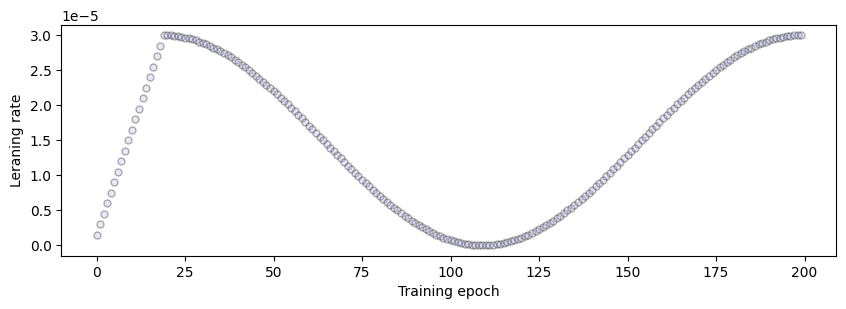

In [25]:
lrs = np.zeros(training_steps)
for i in range(training_steps):
    optim.step() # update the optim
    scheduler.step() #run the scheduler
    lrs[i] = scheduler.get_last_lr()[0] # get the actual lr

plt.figure(figsize=(10,3))
plt.plot(lrs,'ko',markersize=5, markerfacecolor=[.7,.7,.9],alpha=.3)

plt.gca().set(xlabel='Training epoch',ylabel='Leraning rate')
plt.show()

In [ ]:
# we get a cosine graph because num_cycles was set to 1